In [1]:
import pandas as pd
import numpy as np
import scipy
import pylab 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set()
%matplotlib inline

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv('../data/train.csv')
weather = pd.read_csv('../data/weather.csv')
key = pd.read_csv('../data/key.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sampleSubmission.csv')

## Target Analysis

In [3]:
# 2013-03-31
train_df = train[:2255853]

In [4]:
train_df.describe()

,store_nbr,item_nbr,units
count,2.255853e+06,2.255853e+06,2.255853e+06
mean,2.291025e+01,5.600000e+01,1.104954e+00
std,1.299397e+01,3.204165e+01,1.096582e+01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.200000e+01,2.800000e+01,0.000000e+00
50%,2.300000e+01,5.600000e+01,0.000000e+00
75%,3.400000e+01,8.400000e+01,0.000000e+00
max,4.500000e+01,1.110000e+02,5.568000e+03


In [4]:
# Basic Stats
train_df['units'].describe()

count    2.255853e+06
mean     1.104954e+00
std      1.096582e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.568000e+03
Name: units, dtype: float64

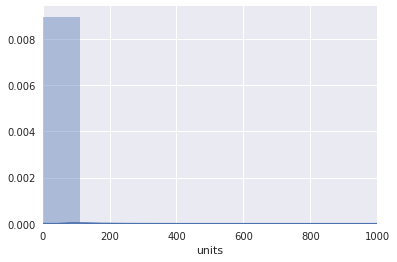

In [5]:
# Histogram
sns.distplot(train_df['units'])
plt.xlim(0, 1000)
plt.show()
# Too many zeroes....

In [6]:
# Take log to see if it helps
train_df['log_units'] = np.log(train_df['units'] + 1)
train_df['log_units'].describe()

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count    2.255853e+06
mean     7.959207e-02
std      5.309945e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.624971e+00
Name: log_units, dtype: float64

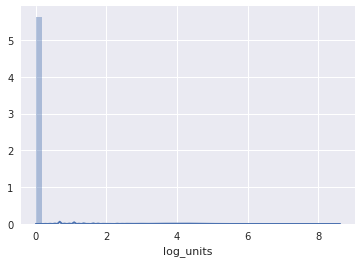

In [7]:
sns.distplot(train_df['log_units'])
plt.show()
# Nope not really

In [8]:
# let's see it by item number
train_norm_test = train_df.pivot_table(values='units', index=['store_nbr', 'date'], columns=['item_nbr'])
train_norm_test_log = train_df.pivot_table(values='log_units', index=['store_nbr', 'date'], columns=['item_nbr'])

## Normality Test

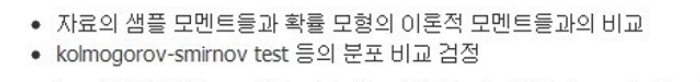

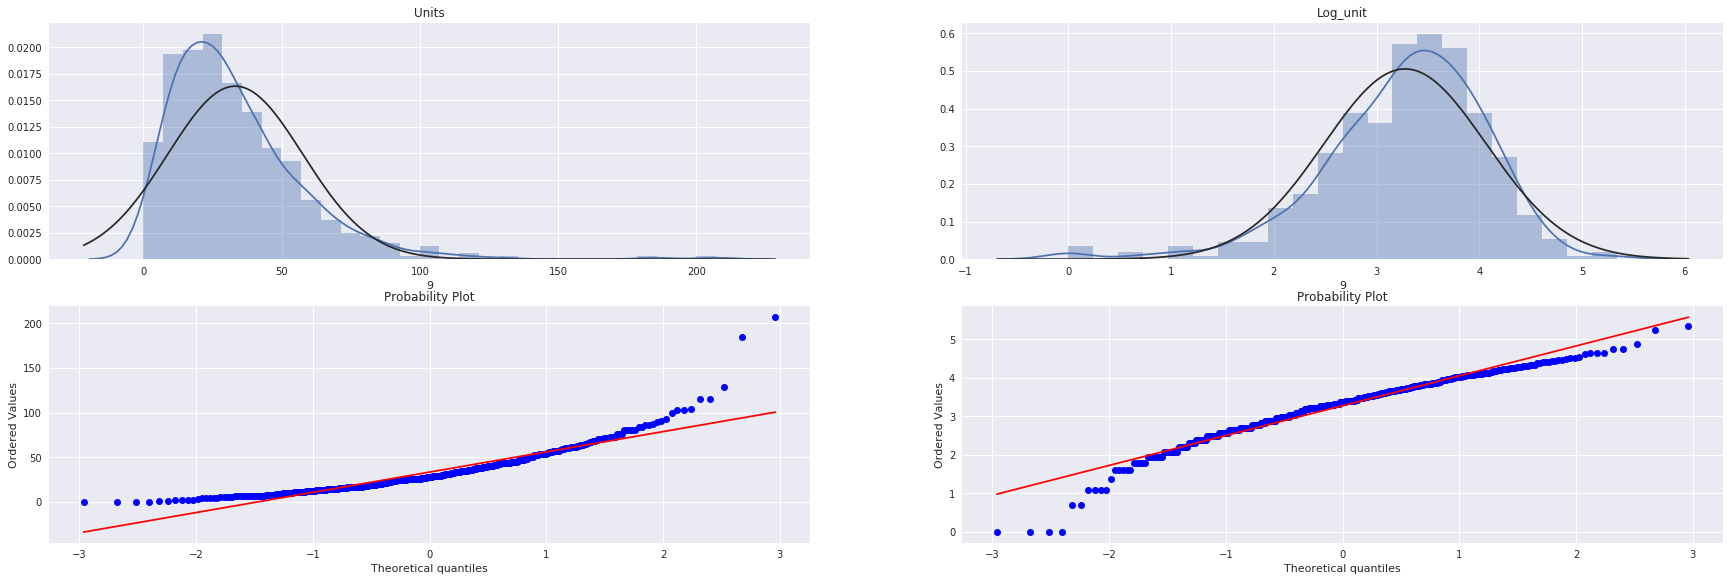

IndexError: invalid index to scalar variable.

In [25]:
# Let's draw per item_nbr per store_nbr * with units
plt.figure(figsize = (30, 20))
plt.subplot(4,2,1)
sns.distplot(train_norm_test.loc[1][9], kde=True, fit=scipy.stats.norm)
plt.title('Units')
plt.subplot(4,2,2)
sns.distplot(train_norm_test_log.loc[1][9], kde=True, fit=scipy.stats.norm)
plt.title('Log_unit')
plt.subplot(4,2,3)
scipy.stats.probplot(train_norm_test.loc[1][9], dist="norm", plot=pylab)
plt.subplot(4,2,4)
scipy.stats.probplot(train_norm_test_log.loc[1][9], dist="norm", plot=pylab)
pylab.show()
result_ks = scipy.stats.kstest(train_norm_test.loc[1][9], cdf='norm')
result_ks_log = scipy.stats.kstest(train_norm_test_log.loc[1][9], cdf='norm')
print('Unit - test statistic: {}, p-value: {}'.format(result_ks[0], result_ks[1][2]))
print('Log Unit - test statistic: {}, p-value: {}'.format(result_ks_log[0], result_ks_log[1][2]))
print("Unit - Skewness: %f" % train_norm_test.loc[1][9].skew())
print("Unit - Kurtosis: %f" % train_norm_test.loc[1][9].kurt())
print("Log Unit - Skewness: %f" % train_norm_test_log.loc[1][9].skew())
print("Log Unit - Kurtosis: %f" % train_norm_test_log.loc[1][9].kurt())
# It seems like improving the normality!

In [5]:
def TM_transform(series, T_replace): 
    """
    데이터내의 T, M을 원하는 값으로 바꿔주는 함수
    TM_transform(series, T_replace)
    """
    series = series.astype(str).map(lambda s: s.strip())
    series[series == 'T'] = T_replace
    window = 3
    for i in range(len(series)) :
        if series.at[i] == 'M' :
            tmp = 0.0
            if i == 0:
                result = 0.0
            else:
                for x in range(1, window + 1) :
                    tmp += float(series.at[i - x])
                    result = round(tmp / window, 2)
            series.set_value(i, result) 
    return series.astype('float')

In [6]:
def match_dateformat(df, year):
    """
    영문 월을 숫자 월로 바꾸어주고 나중에 사용하기 쉽도록 datetime.date 형태로 바꾸어주는 함수
    """
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(len(df)):
        dates = df.loc[i][0]
        dates = dates.split(" ")
        for j in range(len(months)):
            if dates[0] == months[j]:
                dates[0] = str(j + 1)
                dates_df = ["{} {} {}".format(year, dates[0], dates[1])]
                dates_df = pd.to_datetime(dates_df)
                df.loc[i][0] = dates_df.date[0]
    return df

In [7]:
def merge_holiday(holiday_df1, holiday_df2, holiday_df3):
    """
    각 연도별 공휴일 리스트 합치기
    """
    frame = [holiday_df1, holiday_df2, holiday_df3]
    holiday = pd.concat(frame).reset_index(drop=True)
    return holiday

In [8]:
def find_holiday(file, year):
    """
    수요에 영향을 미치는 주요 공휴일을 찾아내는 함수
    """
    holidays = ["New Year's Day", "Martin Luther King Jr. Day", "Valentine's Day",  "President's Day", "Easter Sunday", 
                      "Mother's Day", "Memorial Day", "Father's Day", "Independence Day", "Labor Day", "Columbus Day",
                      "Halloween", "Veterans Day", "Thanksgiving Day", "Black Friday", "Christmas Eve", "Christmas Day", "New Year's Eve"]
    
    holi = pd.read_excel(file, year, header=None)
    holi = match_dateformat(holi, year)
    holiday = pd.DataFrame(columns=[0,1,2,3,4])
    for _ in holidays:
        for i in range(len(holi[2])):
            if _ == holi[2][i]:
                holiday = holiday.append(holi.loc[i])
    return holiday

In [9]:
def cs_preprocessing(codesum):
    codesum_temp = []
    for _ in codesum:
        _ = _.replace('+', '')
        _ = _.replace('-', '')
        if len(_) > 2:
            _1 = _[:2]
            codesum_temp.append(_1)
            _2 = _[2:]
            codesum_temp.append(_2)
        else:
            codesum_temp.append(_)
    codesum = codesum_temp
    return codesum

In [10]:
def weather_flagger(weather):
    codesum_ls = ['FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL', 'IC', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']
    weather['date'] = pd.to_datetime(weather['date']) #weather는 글로벌변수
    for i in range(len(weather['codesum'])):
        codesum = weather['codesum'][i].split(" ")
        codesum = cs_preprocessing(codesum)
        for _ in codesum:
            flag = any(code in _ for code in codesum_ls)
            if flag == True:
                weather.set_value(i, '{}_flag'.format(_), 1)
            else:
                weather.set_value(i, 'normal_flag', 1)

    # return x or y depending on the condition
    # "For the purposes of this competition, we have defined a weather event as any day in which more than an inch of rain or two inches of snow was observed."
    # weather_event =  (((codesum contains SN) and (snowfall > 2)) or ((codesum contains RA) and (preciptotal > 1)))
    weather['preciptotal'] = TM_transform(weather['preciptotal'], 0.001)
    weather['snowfall'] = TM_transform(weather['snowfall'], 0.001)
    weather['snow_event'] = np.where(np.where(weather['SN_flag'] == 1, 1, 0) + np.where(weather['snowfall'] > 2, 1, 0) == 2, 1, 0)
    weather['rain_event'] = np.where(np.where(weather['RA_flag'] == 1, 1, 0) + np.where(weather['preciptotal'] > 1, 1, 0) == 2, 1, 0)
    weather['event'] = weather['snow_event'] + weather['rain_event']
    weather['event'] = np.where(weather['event'] >= 1, 1, 0)
    #    weather['preciptotal_flag'] = np.where(weather['preciptotal'] > 0.2, 1, 0)
    #     weather['depart'] = TM_transform(weather['depart'], np.nan, 0.00)
    #     weather['depart_flag'] = np.where(weather['depart'] > 8.0, 1, 0)
    #     weather['depart_flag'] = np.where(weather['depart'] < 8.0, -1, 0)
    return weather

In [11]:
def test_preprocessing(df, holiday, weather):
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'RA_flag', 'SN_flag', 'normal_flag', 'event']], on=['date', 'station_nbr'])
    return df

In [12]:
def preprocessing(df, holiday, weather):
    """
    train데이터를 가공하는 함수
    """
    df['units'] = np.log(df['units'] + 1) # logged units
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df.date.dt.weekday  # 월요일이 0 일요일이 6
    df['weekend'] = df.date.dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

    df['holiday'] = df.date.isin(holiday[0])
    df['weekday_holiday'] = df.holiday & (df.weekend == False)
    df['weekend_holiday'] = df.holiday & df.weekend
    
    df = pd.merge(df, key, on='store_nbr') #key는 글로벌 변수
    df = pd.merge(df, weather[['date', 'station_nbr', 'RA_flag', 'SN_flag', 'normal_flag', 'event', 'snowfall', 'preciptotal']], on=['date', 'station_nbr'])
    return df

In [13]:
holiday12 = find_holiday('../data/holiday.xlsx', '2012')
holiday13 = find_holiday('../data/holiday.xlsx', '2013')
holiday14 = find_holiday('../data/holiday.xlsx', '2014')
holiday = merge_holiday(holiday12, holiday13, holiday14)
weather = weather_flagger(weather)
processed_train = preprocessing(train, holiday, weather)
processed_test = test_preprocessing(test, holiday, weather)

/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/home/yjoung90/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [ ]:
event_pivot_station_train = processed_train.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_station_test = processed_test.pivot_table(values='event', index='date', columns='station_nbr')
event_pivot_store_train = processed_train.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_store_test = processed_test.pivot_table(values='event', index='date', columns='store_nbr')
event_pivot_station_train = pd.DataFrame(event_pivot_station_train.to_records())
event_pivot_station_test = pd.DataFrame(event_pivot_station_test.to_records())
event_pivot_store_train = pd.DataFrame(event_pivot_store_train.to_records())
event_pivot_store_test = pd.DataFrame(event_pivot_store_test.to_records())

## Weather Event by Station

In [ ]:
date_index_train = [str(event_pivot_station_train.at[num, 'date'])for num in range(len(event_pivot_station_train))]
date_index_test = [str(event_pivot_station_test.at[num, 'date'])for num in range(len(event_pivot_station_test))]

f,  [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20] = plt.subplots(20, sharex = True, figsize = (30, 20))
ax_tp = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20]
plt.ylim(0, 1)

for i in range(1, len(ax_tp) + 1):
    if i != 5:
        ax_tp[i - 1].scatter(date_index_train, event_pivot_station_train[str(i)])
        ax_tp[i - 1].scatter(date_index_test, event_pivot_station_test[str(i)])
        ax_tp[i - 1].set_ylabel('{}'.format(i))   # Y 라벨 
    else:
        try:
            ax_tp[i - 1].scatter(date_index_train, event_pivot_station_train[str(i)])
            ax_tp[i - 1].scatter(date_index_test, event_pivot_station_test[str(i)])
            ax_tp[i - 1].set_ylabel('{}'.format(i))   # Y 라벨 
        except:
            pass

ax_tp[0].set_title("Event")
plt.xlabel('date') # X 라벨
f.subplots_adjust(hspace = 1.25) 
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible = False)

## Weather Event by Store

In [ ]:
date_index_train = [str(event_pivot_store_train.at[num, 'date'])for num in range(len(event_pivot_store_train))]
date_index_test = [str(event_pivot_store_test.at[num, 'date'])for num in range(len(event_pivot_store_test))]

f,  [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21
    , ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40
    , ax41, ax42, ax43, ax44, ax45] = plt.subplots(45, sharex = True, figsize = (30, 30))
ax_tp = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21
    , ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40
    , ax41, ax42, ax43, ax44, ax45]
plt.ylim(0, 1)

for i in range(1, len(ax_tp) + 1):
    if i != 35:
        ax_tp[i - 1].scatter(date_index_train, event_pivot_store_train[str(i)])
        ax_tp[i - 1].scatter(date_index_test, event_pivot_store_test[str(i)])
        ax_tp[i - 1].set_ylabel('{}'.format(i))   # Y 라벨 
    else:
        try:
            ax_tp[i - 1].scatter(date_index_train, event_pivot_store_train[str(i)])
            ax_tp[i - 1].scatter(date_index_test, event_pivot_store_test[str(i)])
            ax_tp[i - 1].set_ylabel('{}'.format(i))   # Y 라벨 
        except:
            pass

ax_tp[0].set_title("Event")
plt.xlabel('date') # X 라벨
f.subplots_adjust(hspace = 1.25) 
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible = False)

## Feature Selection

### Whole Picture

In [14]:
processed_train_cut = processed_train[processed_train['date'] <= '2013-03-31']

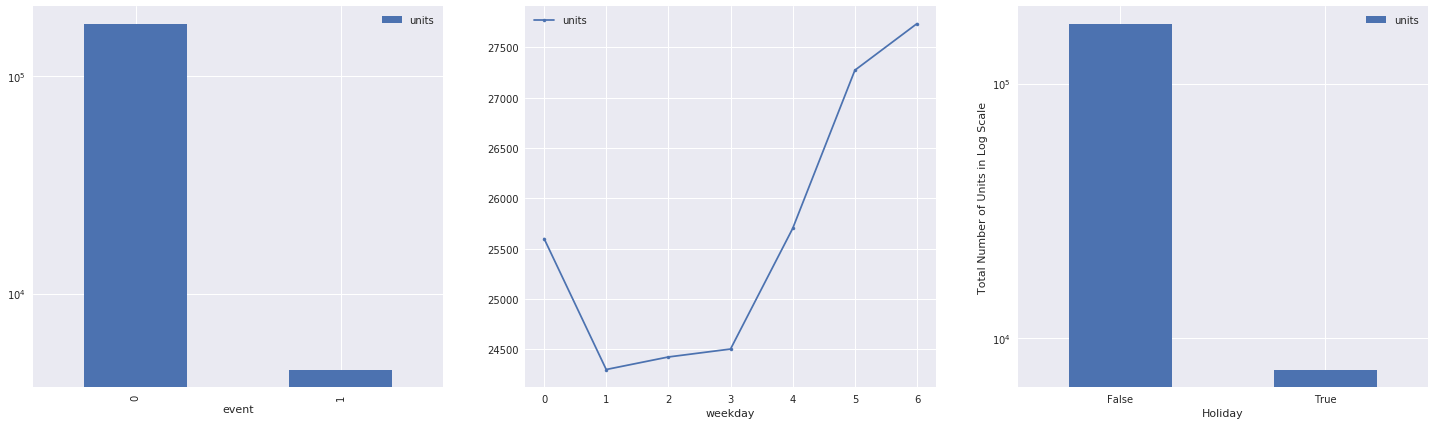

In [15]:
processed_train_f1 = processed_train_cut.pivot_table(values='units', index=['event'], aggfunc=np.sum)
processed_train_f2 = processed_train_cut.pivot_table(values='units', index=['weekday'], aggfunc=np.sum)
processed_train_f3 = processed_train_cut.pivot_table(values='units', index=['holiday'], aggfunc=np.sum)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (25, 7))
# unit vs event
processed_train_f1.plot(kind='bar', logy=True, ax=axes[0])
plt.ylabel('Total Number of Units in Log Scale')
plt.xlabel('Weather Event')
# unit vs weekday
processed_train_f2.plot(kind='line', style='.-', ax=axes[1])
plt.xticks(rotation=0)
plt.ylabel('Total Number of Units')
plt.xlabel('Weekday')
# unit vs holiday
processed_train_f3.plot(kind='bar', logy=True, ax=axes[2])
plt.xticks(rotation=0)
plt.ylabel('Total Number of Units in Log Scale')
plt.xlabel('Holiday')
plt.show()

## By Store

#### Holiday Influence

In [30]:
by_store(processed_train_holiday, 1)

,date,store_nbr,item_nbr,units,weekday,weekend,holiday,weekday_holiday,weekend_holiday,station_nbr,RA_flag,SN_flag,normal_flag,event,snowfall,preciptotal
0,2012-01-01,1,1,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
1,2012-01-01,1,2,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
2,2012-01-01,1,3,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
3,2012-01-01,1,4,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
4,2012-01-01,1,5,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
5,2012-01-01,1,6,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
6,2012-01-01,1,7,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
7,2012-01-01,1,8,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
8,2012-01-01,1,9,3.401197,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
9,2012-01-01,1,10,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05


In [20]:
processed_train_holiday = processed_train_cut[processed_train_cut['holiday'] == True] # holiday만 추려서 dataframe 만듬.
processed_train_nonholiday = processed_train_cut[processed_train_cut['holiday'] == False] # holiday 아닌 날들만 추려서 dataframe 만듬.

In [21]:
def by_store(df, nbr) : # sort by store number and re-index
    df_new = df[df['store_nbr'] == nbr]
    df_new.reset_index(drop = True, inplace = True)
    return df_new

In [25]:
by_store(processed_train_holiday, 1)

,date,store_nbr,item_nbr,units,weekday,weekend,holiday,weekday_holiday,weekend_holiday,station_nbr,RA_flag,SN_flag,normal_flag,event,snowfall,preciptotal
0,2012-01-01,1,1,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
1,2012-01-01,1,2,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
2,2012-01-01,1,3,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
3,2012-01-01,1,4,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
4,2012-01-01,1,5,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
5,2012-01-01,1,6,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
6,2012-01-01,1,7,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
7,2012-01-01,1,8,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
8,2012-01-01,1,9,3.401197,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05
9,2012-01-01,1,10,0.000000,6,True,True,False,True,1,1.0,NaN,NaN,0,0.0,0.05


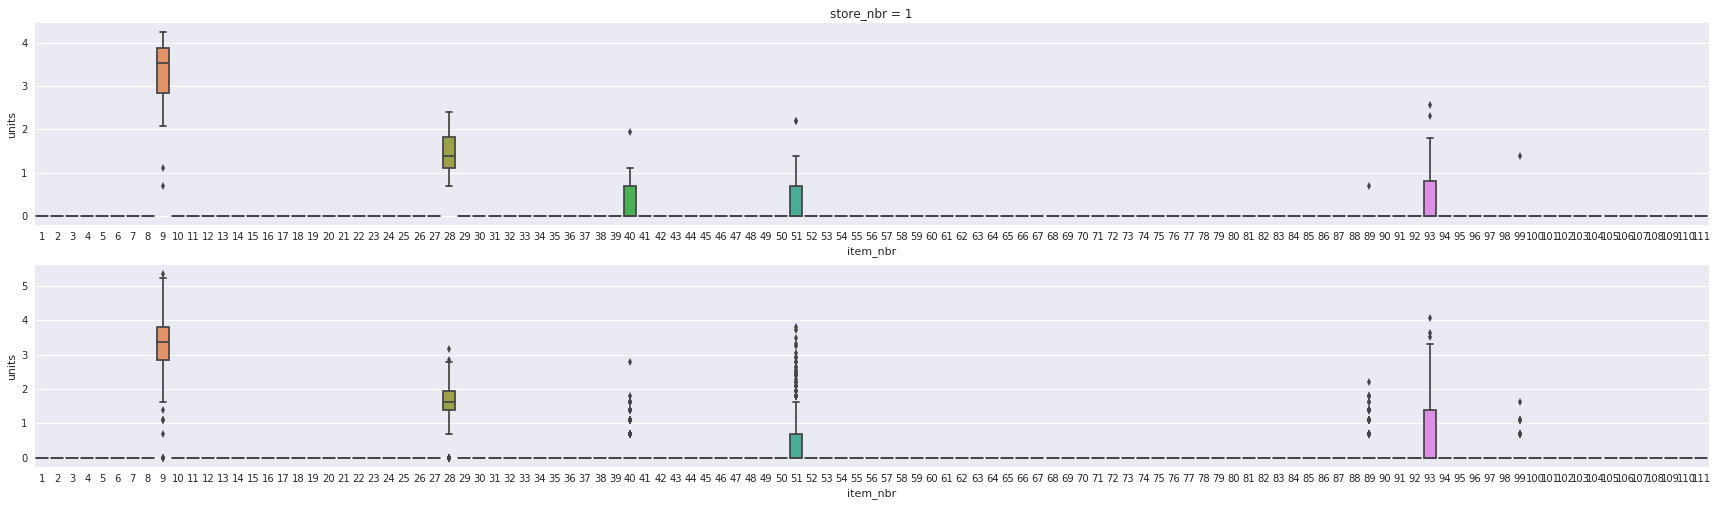

In [26]:
# Let's plot 10 stores first to see if holiday influences the unit demand
for i in range(1, 2):
    plt.subplots(figsize = (30, 400))
    plt.subplot(90,1, i)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_holiday, i)) # holiday
    plt.title('store_nbr = {}'.format(i))
    plt.subplot(90, 1, i + 1)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_nonholiday, i)) # non-holiday
plt.show()

- 10개의 스토어만 놓고 보았을때 공휴일의 영향이 별로 없어보임
- 각 스토어 별로 각 아이템이 휴일에 얼마나 영향을 받는지 units의 평균값과 표준편차로 나타내기

In [ ]:
frames = []
for i in range(1, 46):
    df_holiday_store_item_describe = pd.DataFrame()
    mean = pd.DataFrame(by_store(processed_train_holiday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
    std = pd.DataFrame(by_store(processed_train_holiday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
    df_holiday_store_item_describe['item_nbr'] = mean.index + 1
    df_holiday_store_item_describe['store_nbr'] = i 
    df_holiday_store_item_describe['mean'] = mean['units']
    df_holiday_store_item_describe['stdev'] = std['units']
    frames.append(df_holiday_store_item_describe)
df_holiday_store_item_describe = pd.concat(frames)
df_holiday_store_item_describe = df_holiday_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
frames = []
for i in range(1, 46):
    df_nonholiday_store_item_describe = pd.DataFrame()
    mean = pd.DataFrame(by_store(processed_train_nonholiday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
    std = pd.DataFrame(by_store(processed_train_nonholiday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
    df_nonholiday_store_item_describe['item_nbr'] = mean.index + 1
    df_nonholiday_store_item_describe['store_nbr'] = i 
    df_nonholiday_store_item_describe['mean'] = mean['units']
    df_nonholiday_store_item_describe['stdev'] = std['units']
    frames.append(df_nonholiday_store_item_describe)
df_nonholiday_store_item_describe = pd.concat(frames)
df_nonholiday_store_item_describe = df_nonholiday_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
df_difference = df_holiday_store_item_describe - df_nonholiday_store_item_describe

df_difference['mean'][3].plot(kind='line', legend=False, title='Mean Difference')
plt.ylabel('Mean')
plt.show()

In [ ]:
df_difference['max_mean_diff'] = df_difference['mean'].max(axis=1)
df_difference['min_mean_diff'] =  df_difference['mean'].min(axis=1)
# Convert it to the actual units (it is logged in the beginning)
df_difference['max_mean_diff_actual'] = np.exp(df_difference['mean'].max(axis=1)) - 1
df_difference['min_mean_diff_actual'] =  np.exp(df_difference['mean'].min(axis=1)) - 1
print('Maximum mean difference is : {}'.format(df_difference['max_mean_diff_actual'].max(axis=0)))
print('Minimum mean difference is : {}'.format(df_difference['min_mean_diff_actual'].min(axis=0)))
# 최대 0.5 정도의 차이가 남

### Thanksgiving Day

In [ ]:
train_plot = processed_train_cut.pivot_table(values = 'units', index = ['date'], columns = ['item_nbr'], aggfunc = np.mean) #units는 0이상임..
plt.figure(figsize = (40, 40))
sns.heatmap(train_plot, cmap = 'BuGn_r')
plt.show()

### Weekend Influence

In [ ]:
processed_train_weekend = processed_train_cut[processed_train_cut['weekend'] == True] # holiday만 추려서 dataframe 만듬.
processed_train_businessday = processed_train_cut[processed_train_cut['weekend'] == False] # holiday 아닌 날들만 추려서 dataframe 만듬.

In [ ]:
for i in range(1, 11):
    plt.subplots(figsize = (30, 400))
    plt.subplot(90,1, i)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_weekend, i)) # weekend
    plt.title('store_nbr = {}'.format(i))
    plt.subplot(90, 1, i + 1)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_businessday, i)) # businessday
plt.show()

- 10개의 스토어만 놓고 보았을때 평일 주말의 영향이 별로 없어보임
- 각 스토어 별로 각 아이템이 에 주말 영향을 받는지 units의 평균값과 표준편차로 나타내기

In [ ]:
frames = []
for i in range(1, 46):
    df_weekend_store_item_describe = pd.DataFrame()
    mean = pd.DataFrame(by_store(processed_train_weekend,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
    std = pd.DataFrame(by_store(processed_train_weekend,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
    df_weekend_store_item_describe['item_nbr'] = mean.index + 1
    df_weekend_store_item_describe['store_nbr'] = i 
    df_weekend_store_item_describe['mean'] = mean['units']
    df_weekend_store_item_describe['stdev'] = std['units']
    frames.append(df_weekend_store_item_describe)
df_weekend_store_item_describe = pd.concat(frames)
df_weekend_store_item_describe = df_weekend_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
frames = []
for i in range(1, 46):
    df_businessday_store_item_describe = pd.DataFrame()
    mean = pd.DataFrame(by_store(processed_train_businessday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
    std = pd.DataFrame(by_store(processed_train_businessday,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
    df_businessday_store_item_describe['item_nbr'] = mean.index + 1
    df_businessday_store_item_describe['store_nbr'] = i 
    df_businessday_store_item_describe['mean'] = mean['units']
    df_businessday_store_item_describe['stdev'] = std['units']
    frames.append(df_businessday_store_item_describe)
df_businessday_store_item_describe = pd.concat(frames)
df_businessday_store_item_describe = df_businessday_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
df_difference = df_weekend_store_item_describe - df_businessday_store_item_describe

df_difference['mean'][3].plot(kind='line', legend=False, title='Mean Difference')
plt.ylabel('Mean')
plt.show()

In [ ]:
df_difference['max_mean_diff'] = df_difference['mean'].max(axis=1)
df_difference['min_mean_diff'] =  df_difference['mean'].min(axis=1)
# Convert it to the actual units (it is logged in the beginning)
df_difference['max_mean_diff_actual'] = np.exp(df_difference['mean'].max(axis=1)) - 1
df_difference['min_mean_diff_actual'] =  np.exp(df_difference['mean'].min(axis=1)) - 1
print('Maximum mean difference is : {}'.format(df_difference['max_mean_diff_actual'].max(axis=0)))
print('Minimum mean difference is : {}'.format(df_difference['min_mean_diff_actual'].min(axis=0)))
# 최대 0.8 정도의 차이가 남

### Weekday Influence

In [ ]:
processed_train_mon = processed_train_cut[processed_train_cut['weekday'] == 0] # holiday만 추려서 dataframe 만듬.
processed_train_tue = processed_train_cut[processed_train_cut['weekday'] == 1]
processed_train_wed = processed_train_cut[processed_train_cut['weekday'] == 2]
processed_train_thu = processed_train_cut[processed_train_cut['weekday'] == 3]
processed_train_fri = processed_train_cut[processed_train_cut['weekday'] == 4]
processed_train_sat = processed_train_cut[processed_train_cut['weekday'] == 5]
processed_train_sun = processed_train_cut[processed_train_cut['weekday'] == 6]

In [ ]:
for i in range(1, 11):
    plt.subplots(figsize = (30, 400))
    plt.subplot(315,1, i)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_mon, i))
    plt.title('store_nbr = {}'.format(i))
    plt.subplot(315, 1, i + 1)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_tue, i))
    plt.subplot(315, 1, i + 2)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_wed, i))
    plt.subplot(315, 1, i + 3)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_thu, i))
    plt.subplot(315, 1, i + 4)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_fri, i))
    plt.subplot(315, 1, i + 5)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_sat, i))
    plt.subplot(315, 1, i + 6)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_sun, i))
plt.show()

### Weather Influence

In [16]:
processed_train_event = processed_train_cut[processed_train_cut['event'] == 1] # Stormy day만추려서 dataframe 만듬.
processed_train_noevent = processed_train_cut[processed_train_cut['event'] == 0] # 평범한 날들만 추려서 dataframe 만듬.

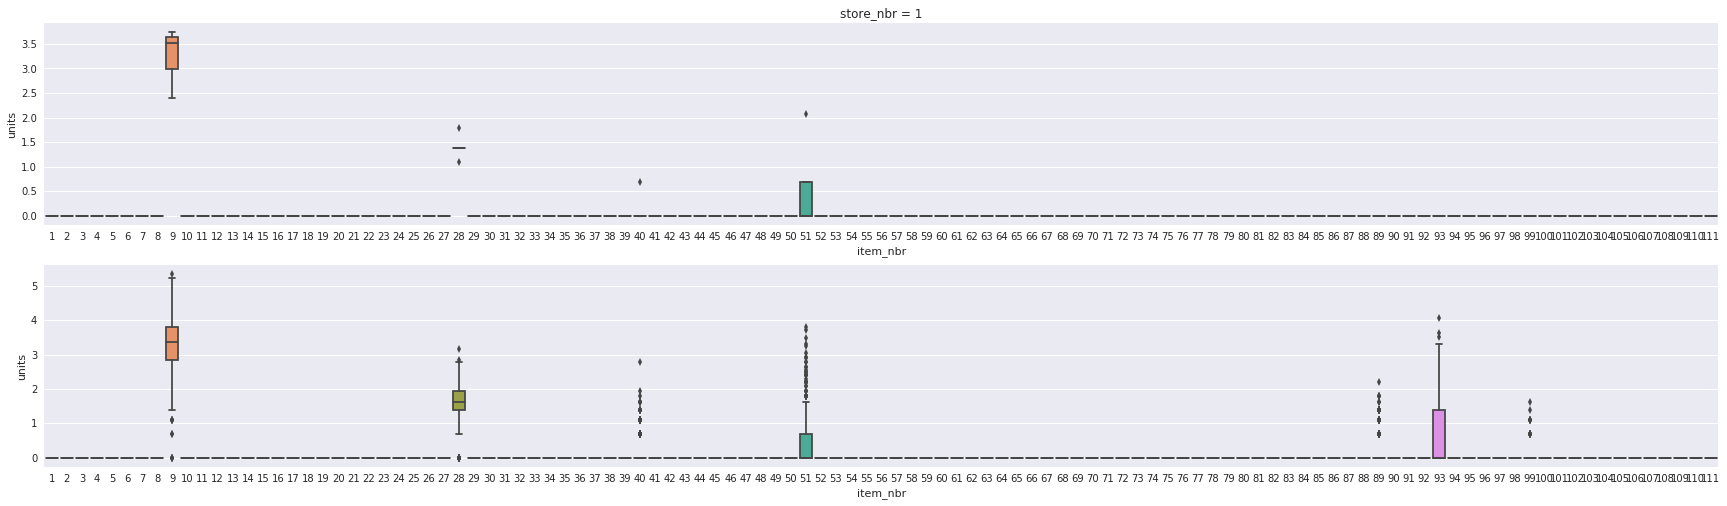

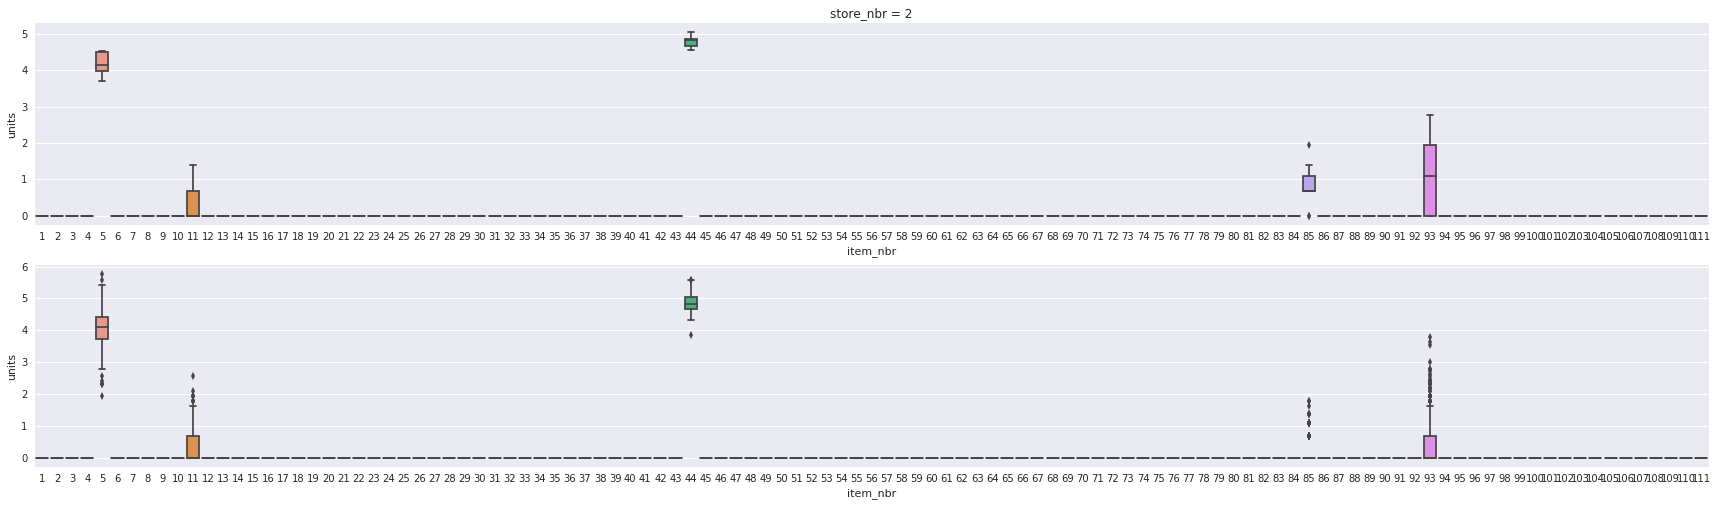

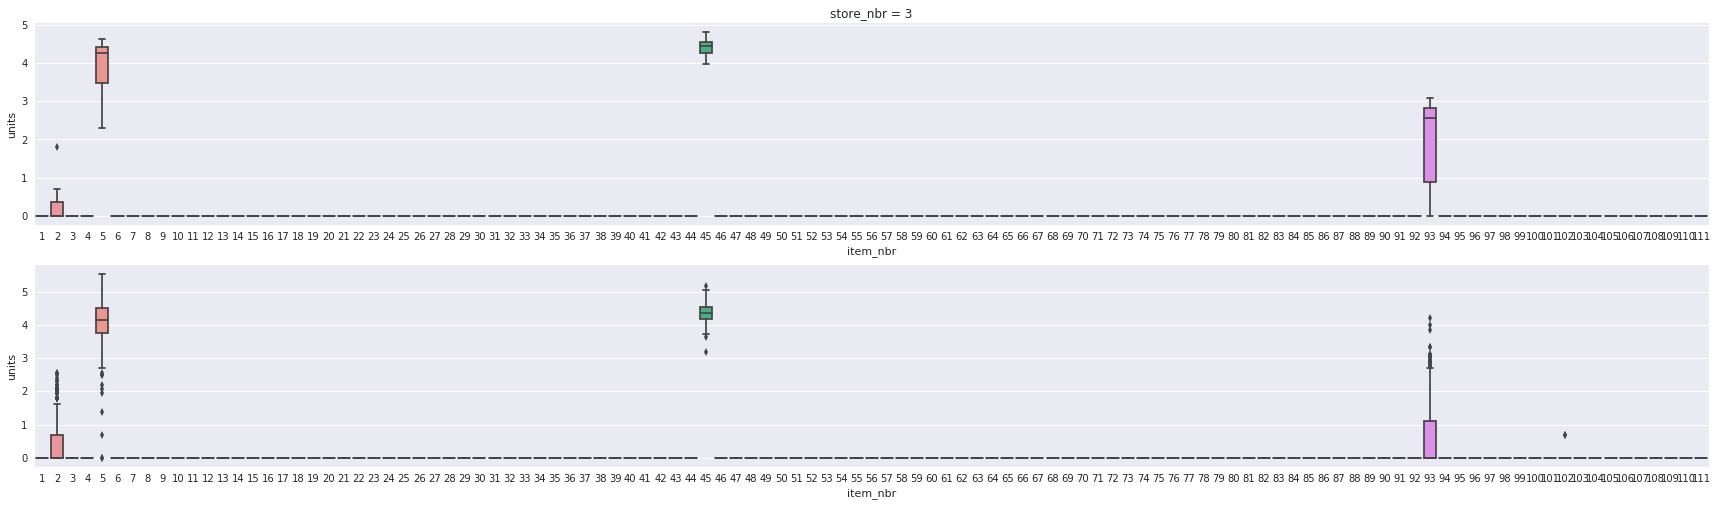

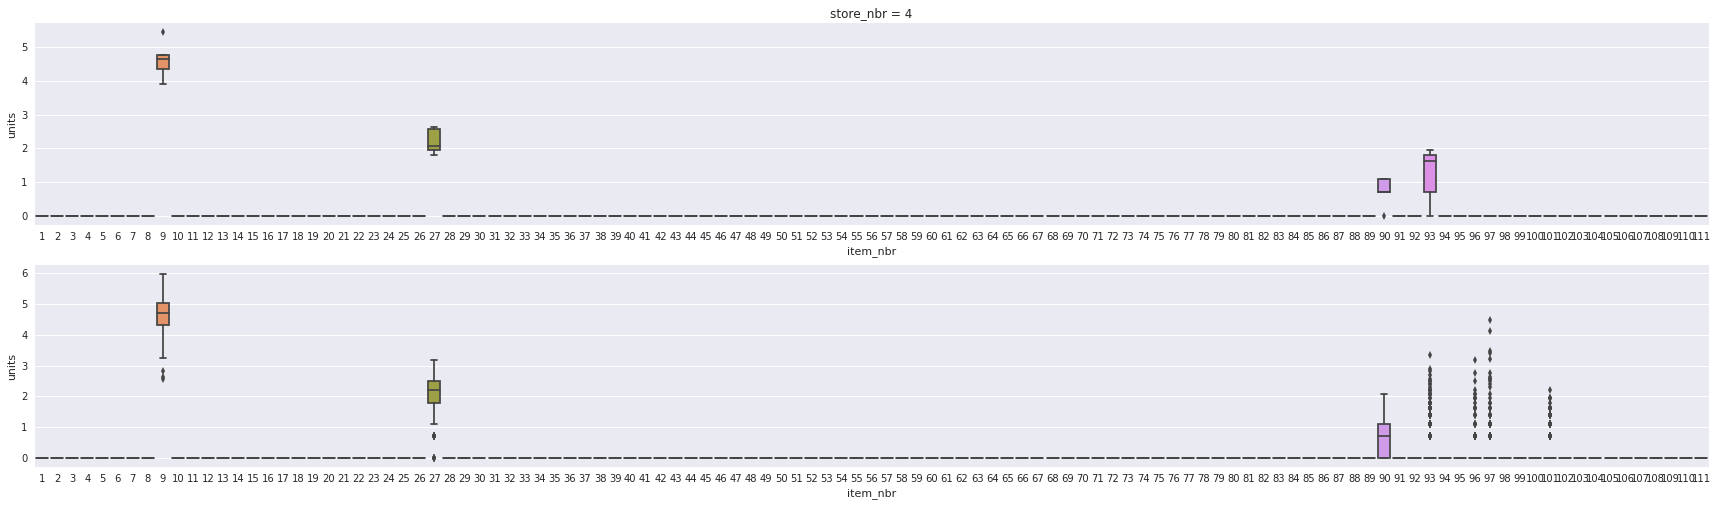

KeyboardInterrupt: 

In [19]:
for i in range(1, 11):
    plt.subplots(figsize = (30, 400))
    plt.subplot(90,1, i)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_event, i)) # weekend
    plt.title('store_nbr = {}'.format(i))
    plt.subplot(90, 1, i + 1)
    sns.boxplot(x = 'item_nbr', y = 'units', data = by_store(processed_train_noevent, i)) # businessday
plt.show()

In [ ]:
frames = []
for i in range(1, 46):
    if i != 35:
        df_event_store_item_describe = pd.DataFrame()
        mean = pd.DataFrame(by_store(processed_train_event,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
        std = pd.DataFrame(by_store(processed_train_event,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
        df_event_store_item_describe['item_nbr'] = mean.index + 1
        df_event_store_item_describe['store_nbr'] = i 
        df_event_store_item_describe['mean'] = mean['units']
        df_event_store_item_describe['stdev'] = std['units']
        frames.append(df_event_store_item_describe)
    else:
        df_event_store_item_describe = pd.DataFrame()
        df_event_store_item_describe['item_nbr'] = range(1, 112)
        df_event_store_item_describe['store_nbr'] = 35
        df_event_store_item_describe['mean'] = 0
        df_event_store_item_describe['stdev'] = 0
        frames.append(df_event_store_item_describe)
df_event_store_item_describe = pd.concat(frames)
df_event_store_item_describe = df_event_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
frames = []
for i in range(1, 46):
    df_noevent_store_item_describe = pd.DataFrame()
    mean = pd.DataFrame(by_store(processed_train_noevent,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.mean).to_records())
    std = pd.DataFrame(by_store(processed_train_noevent,i).pivot_table(values='units', index=['item_nbr'], aggfunc=np.std).to_records())
    df_noevent_store_item_describe['item_nbr'] = mean.index + 1
    df_noevent_store_item_describe['store_nbr'] = i 
    df_noevent_store_item_describe['mean'] = mean['units']
    df_noevent_store_item_describe['stdev'] = std['units']
    frames.append(df_noevent_store_item_describe)
df_noevent_store_item_describe = pd.concat(frames)
df_noevent_store_item_describe = df_noevent_store_item_describe.pivot_table(index=['item_nbr'], columns=['store_nbr'], values=['mean', 'stdev'])

In [ ]:
df_difference = df_event_store_item_describe - df_noevent_store_item_describe
df_difference['mean'][3].plot(kind='line', legend=False, title='Mean Difference')
plt.ylabel('Mean')
plt.show()

In [ ]:
df_difference['max_mean_diff'] = df_difference['mean'].max(axis=1)
df_difference['min_mean_diff'] =  df_difference['mean'].min(axis=1)
# Convert it to the actual units (it is logged in the beginning)
df_difference['max_mean_diff_actual'] = np.exp(df_difference['mean'].max(axis=1)) - 1
df_difference['min_mean_diff_actual'] =  np.exp(df_difference['mean'].min(axis=1)) - 1
print('Maximum mean difference is : {}'.format(df_difference['max_mean_diff_actual'].max(axis=0)))
print('Minimum mean difference is : {}'.format(df_difference['min_mean_diff_actual'].min(axis=0)))
# 최대 5 정도의 차이가 남

In [ ]:
df_difference['max_mean_diff_actual'].plot(kind='line')
plt.show()

## OLS

In [ ]:
processed_train_cut.sort_values(by = ['date', 'store_nbr', 'item_nbr'], inplace=True)
processed_train_cut.reset_index(drop=True, inplace=True)
processed_train_cut1 = processed_train_cut

In [ ]:
tmp = processed_train_cut1.pivot_table(values = 'units', index = ['date'], columns = ['store_nbr','item_nbr'])
item_nbr_total = list(tmp.columns)
tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]
item_nbr_nonzero = list(tmp.columns)

item_nbr_total_list = []
for i in range(len(item_nbr_total)):
    item_nbr_total_list.append(item_nbr_total[i][1])

item_nbr_sold = []
for i in range(len(item_nbr_nonzero)):
    item_nbr_sold.append(item_nbr_nonzero[i][1])
    

    
item_nbr_zero = []
for num in item_nbr_total_list :
    if num not in item_nbr_sold :
        item_nbr_zero.append(num)

In [ ]:
item_nbr_nonzero

### 짤라주세요  ㅜㅜㅜㅜ

In [ ]:
# for i in range(1, 46): 
for num in item_nbr_sold:
#         processed_train_cut1 = processed_train_cut1[processed_train_cut1['store_nbr'] == i]
    processed_train_cut1 = processed_train_cut1[processed_train_cut1.item_nbr == num]

In [ ]:
processed_train_cut1

In [ ]:
train_new = train_df[:2255853]

In [ ]:
item_nbr_nonzero

In [ ]:
tmp = train_new.pivot_table(values = 'log_units', index = 'date', columns = 'item_nbr')
item_nbr_total = list(tmp.columns)
tmp = tmp.loc[:, (tmp != 0).any(axis = 0)]
item_nbr_nonzero = list(tmp.columns)
item_nbr_zero = []
for num in item_nbr_total :
    if num not in item_nbr_nonzero :
        item_nbr_zero.append(num)
for num in item_nbr_zero :
    train_new_ = train_new[train_new.item_nbr != num]
train_new_.reset_index(drop = True, inplace = True)
processed_train_cut2 = preprocessing(train_new_, holiday, weather)

In [ ]:
processed_train_cut2

In [ ]:
processed_train_cut1['store_nbr'] = processed_train_cut1['store_nbr'].astype('category')
processed_train_cut1['item_nbr'] = processed_train_cut1['item_nbr'].astype('category')
processed_train_cut1['weekday'] = processed_train_cut1['weekday'].astype('category')
processed_train_cut1['event'] = processed_train_cut1['event'].astype('category')
processed_train_cut1['holiday'] = processed_train_cut1['holiday'].astype('category')

In [ ]:
model = sm.OLS.from_formula('units ~ store_nbr + item_nbr + weekday + event + holiday', data=processed_train_cut1)
result = model.fit()
print(result.summary())